In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("http://www.amlbook.com/data/zip/features.train", header = None, delimiter = r"\s+")
df.columns = ['number', 'intensity', 'symmetry']
df['number'] = df['number'].astype(int) 
df.head(3)

,number,intensity,symmetry
0,6,0.341092,-4.528937
1,5,0.444131,-5.496812
2,4,0.231002,-2.886750


In [3]:
mask = ((df.number == 1) | (df.number == 5)) # select only numbers '1' and '5'
df = df[mask]
df = df.reset_index(drop = True)
df.head(3)

,number,intensity,symmetry
0,5,0.444131,-5.496812
1,1,0.123043,-0.707875
2,1,0.113859,-0.931375


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1561 entries, 0 to 1560
Data columns (total 3 columns):
number       1561 non-null int64
intensity    1561 non-null float64
symmetry     1561 non-null float64
dtypes: float64(2), int64(1)
memory usage: 36.7 KB


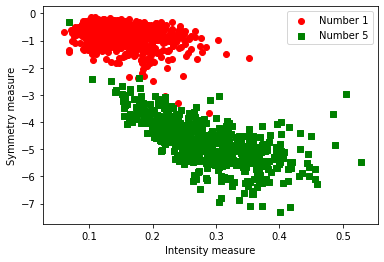

In [5]:
X = df.loc[:, ['intensity', 'symmetry']].values
y = df.loc[:, 'number'].values
y = np.where(y == 1, -1, 1) # maps 1 to -1, and 5 to 1

plt.scatter(X[y == -1, 0], X[y == -1, 1], color = "red", marker = "o", label = "Number 1")
plt.scatter(X[y ==  1, 0], X[y ==  1, 1], color = "green", marker = "s", label = "Number 5")
plt.xlabel("Intensity measure")
plt.ylabel("Symmetry measure")
plt.legend(loc = 1)
plt.show()

In [6]:
# Raw implementation
class Pocket:
    """
    Pocket learning algorithm implementation
    """
    
    def __init__(self, eta = 1, random_seed = 1, n_iterations = 100):
        self.eta = eta
        self.random_seed = random_seed
        self.n_iterations = n_iterations 
    
    def fit(self, X, y):
        rn = np.random.RandomState(self.random_seed)
        self.w_ = rn.normal(loc = 0, scale = 0.01, size = X.shape[1] + 1)
        counter = 0
        errors = True
        
        partial_w = self.w_.copy()
        partial_error_in_sample = 0
        self.error_in_sample_ = 0 
        
        while errors and (counter < self.n_iterations):
            errors = 0
            error_freq = 0
            for X_i, y_i in zip(X, y):
                if y_i != self.predict(X_i):
                    # update weights for misclassified points
                    update = self.eta * y_i
                    self.w_[1:] += update * X_i
                    self.w_[0] += update
                    errors += 1    
            for X_i, y_i in zip(X, y):
                if y_i != self.predict(X_i):
                    # count misclassified points AFTER analyze all of them 
                    error_freq += 1
                partial_error_in_sample = (1 / X.shape[0]) * error_freq
            if (counter == 0) or (partial_error_in_sample < self.error_in_sample_):
                # update smallest error and best weights vector
                self.error_in_sample_ = partial_error_in_sample  
                partial_w = self.w_.copy()
            counter += 1
            
        self.w_ = partial_w.copy()
        return self
    
    def predict(self, X_i):
        eval_func = np.dot(X_i, self.w_[1:]) + self.w_[0]
        return np.where(eval_func >= 0, 1, -1)

In [7]:
my_pocket = Pocket(n_iterations = 100)
my_pocket.fit(X, y)

print("Weights vector: {}.".format(my_pocket.w_))
print("Smallest error in-sample: {}.".format(my_pocket.error_in_sample_))

Weights vector: [-9.98375655 -1.494057   -4.21659422].
Smallest error in-sample: 0.0038436899423446506.


In [8]:
def plot_decision_regions(X, y, classifier, feature_names, resolution = 0.01, plot_lim = 0.25):
    # general settings
    markers = ["o", "s", "*", "x", "v"]
    colors  = ("red", "green", "blue", "gray", "cyan")
    x1_min, x1_max = X[:, 0].min() - plot_lim, X[:, 0].max() + plot_lim
    x2_min, x2_max = X[:, 1].min() - plot_lim, X[:, 1].max() + plot_lim
    # define a grid
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    # classify each grid point
    result = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    result = result.reshape(xx1.shape)
    # make a plot
    plt.contourf(xx1, xx2, result, colors = colors[0:len(np.unique(y))], alpha = 0.5)
    for index, value in enumerate(np.unique(y)): 
        plt.scatter(x = X[y == value, 0], y = X[y == value, 1], 
                    color = colors[index],
                    marker = markers[index],
                    label = feature_names[index],
                    edgecolor = 'black')

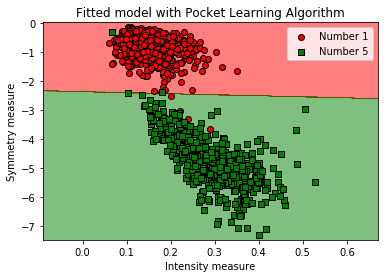

In [9]:
feature_names = ['Number 1', 'Number 5']
plot_decision_regions(X, y, my_pocket, feature_names, plot_lim = 0.15)
plt.title("Fitted model with Pocket Learning Algorithm")
plt.xlabel("Intensity measure")
plt.ylabel("Symmetry measure")
plt.legend(loc = 1)
plt.show()